# Lab: Building a Model Evaluator with LangGraph

This notebook refactors our previous model comparison script into a stateful, robust agent using LangGraph. By structuring the workflow as a graph, we gain better control, observability, and the ability to easily extend the process in the future.

### Key Features:
1.  **Stateful Agent**: The entire workflow is managed within a `StateGraph`.
2.  **Modular Nodes**: Each logical step (generating a question, querying models, judging) is a separate, well-defined node.
3.  **Configuration Driven**: Uses a `config.ini` file for settings.
4.  **Visualization**: Displays a diagram of the agent's graph structure.

## 1. Setup and Installation

In [ ]:
!pip install python-dotenv openai langgraph ipykernel langchain

## 2. Imports and Configuration Loading

**Purpose**: To import necessary libraries and load all settings from our external `config.ini` file.

In [ ]:
import os
import json
import warnings
import configparser
from dotenv import load_dotenv
from openai import OpenAI
from IPython.display import Markdown, display, Image
from typing import TypedDict, List
from langgraph.graph import StateGraph, END, START
# NEW IMPORT for text splitter
from langchain.text_splitter import RecursiveCharacterTextSplitter

warnings.filterwarnings('ignore')

try:
    load_dotenv("dev.env")
    config = configparser.ConfigParser()
    config.read('1-config.ini')

    # Model settings
    JUDGE_MODEL = config.get('Models', 'judge_model')
    competitor_models_str = config.get('Models', 'competitor_models')
    competitor_models = [model.strip() for model in competitor_models_str.split(',')]
    
    # NEW: Chunk size for large answers
    CHUNK_SIZE = config.getint('Parameters', 'chunk_size', fallback=2000)
    CHUNK_OVERLAP = config.getint('Parameters', 'chunk_overlap', fallback=200)

    print("Configuration loaded successfully!")
    print(f"Competitor models: {competitor_models}")
    print(f"Chunk Size: {CHUNK_SIZE}, Chunk Overlap: {CHUNK_OVERLAP}")

except Exception as e:
    print(f"Error loading configuration: {e}")


Configuration loaded successfully!
Competitor models: ['gpt-3.5-turbo', 'gpt-4o', 'gpt-4o-mini']


## 3. Define the Agent's State

**Purpose**: To define the data structure that will act as the agent's memory. This `GraphState` will be passed to every node in our graph.

In [ ]:

class GraphState(TypedDict):
    """Represents the state of our model evaluation workflow."""
    question: str
    competitor_models: List[str]
    answers: List[dict]
    # NEW: key to store chunked answers
    chunked_answers: List[dict]
    judgement: str
    error_message: str

## 4. Define the Agent's Nodes

**Purpose**: To create the functions that will perform the actual work. Each function takes the current state as input and returns a dictionary with the values to update in the state.

In [ ]:
def chunk_answers_node(state: GraphState):
    """Chunks long answers to avoid token limit issues."""
    print("--- NODE: Chunking Answers ---")
    answers = state['answers']
    chunked_answers = []

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=CHUNK_SIZE,
        chunk_overlap=CHUNK_OVERLAP,
        length_function=len
    )

    for answer in answers:
        long_answer = answer['answer']
        # Only chunk if the answer is long (e.g., > 1000 characters)
        if len(long_answer) > CHUNK_SIZE:
            chunks = text_splitter.split_text(long_answer)
            print(f"  - Answer from {answer['model']} was chunked into {len(chunks)} parts.")
            # Store chunks in the state along with original metadata
            chunked_answers.append({"model": answer['model'], "chunks": chunks})
        else:
            # If the answer is short, keep it as a single chunk
            chunked_answers.append({"model": answer['model'], "chunks": [long_answer]})

    return {"chunked_answers": chunked_answers}

In [ ]:
def generate_question_node(state: GraphState):
    """Generates the challenge question."""
    print("--- NODE: Generating Question ---")
    request = "Please come up with a challenging, nuanced question that I can ask a number of LLMs to evaluate their intelligence. Answer only with the question, no explanation or preamble."
    messages = [{"role": "user", "content": request}]
    try:
        client = OpenAI()
        response = client.chat.completions.create(model=JUDGE_MODEL, messages=messages)
        question = response.choices[0].message.content
        return {"question": question}
    except Exception as e:
        return {"error_message": f"Failed to generate question: {e}"}

def query_models_node(state: GraphState):
    """Queries each competitor model with the challenge question."""
    print("--- NODE: Querying Competitor Models ---")
    question = state['question']
    models_to_query = state['competitor_models']
    messages = [{"role": "user", "content": question}]
    current_answers = []
    client = OpenAI()

    for model_name in models_to_query:
        print(f"  - Querying {model_name}...")
        try:
            response = client.chat.completions.create(model=model_name, messages=messages)
            answer = response.choices[0].message.content
            current_answers.append({"model": model_name, "answer": answer})
        except Exception as e:
            error_message = f"Could not get response from {model_name}: {e}"
            print(f"    ERROR: {error_message}")
            current_answers.append({"model": model_name, "answer": error_message})

    return {"answers": current_answers}


In [ ]:
def prepare_for_judging_node(state: GraphState):
    """Chunks long answers and initializes the state for the judging loop."""
    print("--- NODE: Preparing for Judging ---")
    answers = state['answers']
    answers_to_rank = []

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=CHUNK_SIZE,
        chunk_overlap=CHUNK_OVERLAP,
        length_function=len,
    )

    for answer in answers:
        long_answer = answer['answer']
        chunks = text_splitter.split_text(long_answer)
        answers_to_rank.append({"model": answer['model'], "chunks": chunks})
    
    return {
        "answers_to_rank": answers_to_rank,
        "current_model_index": 0,
        "current_chunk_index": 0,
        "running_judgment": "No initial judgment.",
    }

In [ ]:
def final_judge_node(state: GraphState):
    """Generates the final ranking based on the cumulative judgment memory."""
    print("--- NODE: Final Judge Ranking ---")
    question = state['question']
    running_judgment = state['running_judgment']
    model_names = [ans['model'] for ans in state['answers_to_rank']]

    final_ranking_prompt = (
        f"You have completed a detailed evaluation of multiple AI models' answers. "
        f"The question was: '{question}'. "
        f"Your final thoughts and comparative analysis are:\n<final_assessment_context>{running_judgment}</final_assessment_context>\n\n"
        f"Based on this cumulative assessment, provide the definitive ranking of the models from best to worst. "
        f"The models were: {', '.join(model_names)}. "
        f"Respond with a JSON object. The object should have a single key, \"results\", "
        f"which is a list of the model names in ranked order. Example: {{\"results\": [\"gpt-4o\", \"gpt-3.5-turbo\"]}}"
    )
    messages = [{"role": "user", "content": final_ranking_prompt}]
    try:
        client = OpenAI()
        response = client.chat.completions.create(model=JUDGE_MODEL, messages=messages, response_format={"type": "json_object"})
        judgement = response.choices[0].message.content
        return {"judgement": judgement}
    except Exception as e:
        return {"error_message": f"Failed to get final judgement: {e}"}

In [ ]:
def send_chunk_to_judge_node(state: GraphState):
    """Sends the next chunk of the current answer to the judge model for evaluation."""
    print("--- NODE: Sending Chunk to Judge ---")
    question = state['question']
    running_judgment = state['running_judgment']
    answers_to_rank = state['answers_to_rank']
    model_index = state['current_model_index']
    chunk_index = state['current_chunk_index']
    
    current_model = answers_to_rank[model_index]['model']
    current_chunk = answers_to_rank[model_index]['chunks'][chunk_index]
    total_chunks = len(answers_to_rank[model_index]['chunks'])

    judge_prompt = (
        f"You are an impartial judge. The question is: '{question}'. "
        f"You are evaluating the answer from model '{current_model}'. "
        f"Here is chunk {chunk_index + 1} of {total_chunks}. "
        f"You may have received previous chunks or other models' answers.\n\n"
        f"Current running judgment:\n<judgment>{running_judgment}</judgment>\n\n"
        f"New chunk to evaluate:\n<chunk>{current_chunk}</chunk>\n\n"
        f"Please provide your updated assessment based on all content you have seen so far. "
        f"Your response should be a single paragraph summary of the updated judgment. Do not provide a final ranking yet."
    )

    messages = [{"role": "user", "content": judge_prompt}]
    try:
        client = OpenAI()
        response = client.chat.completions.create(model=JUDGE_MODEL, messages=messages)
        updated_judgment = response.choices[0].message.content
        return {"running_judgment": updated_judgment, "current_chunk_index": chunk_index + 1}
    except Exception as e:
        print(f"Failed to get judgment for chunk: {e}")
        return {"error_message": f"Failed to get judgment for chunk: {e}"}

In [ ]:
def judge_answers_node(state: GraphState):
    """Uses the judge model to evaluate and rank the chunked answers."""
    print("--- NODE: Judging Answers ---")
    question = state['question']
    chunked_answers = state['chunked_answers']

    all_answers_text = ""
    for index, response in enumerate(chunked_answers):
        # Concatenate all chunks for a given model
        full_response_text = "\n[CHUNK_SEPARATOR]\n".join(response['chunks'])
        all_answers_text += f"--- START OF RESPONSE {index+1} ({response['model']}) ---\n{full_response_text}\n--- END OF RESPONSE {index+1} ---\n\n"

    judge_prompt = (
        f"You are an impartial judge in a competition between multiple AI models. "
        f"Your task is to evaluate each model's response to a question based on clarity, depth, and accuracy. "
        f"The question was: \"{question}\". "
        f"Here are the responses, which may be broken into chunks separated by '[CHUNK_SEPARATOR]'. "
        f"Please read the entire content of each response. "
        f"Rank them from best to worst and respond with a JSON object. "
        f"The object should have a single key, \"results\", which is a list of the competitor numbers (as integers) in ranked order. "
        f"Example: {{\"results\": [2, 1, 3]}}\n\n"
        f"Responses to judge:\n{all_answers_text}"
    )

    messages = [{"role": "user", "content": judge_prompt}]

    try:
        client = OpenAI()
        response = client.chat.completions.create(model=JUDGE_MODEL, messages=messages, response_format={"type": "json_object"})
        judgement = response.choices[0].message.content
        return {"judgement": judgement}
    except Exception as e:
        return {"error_message": f"Failed to get judgement: {e}"}

In [ ]:
def check_next_chunk_node(state: GraphState):
    answers_to_rank = state['answers_to_rank']
    model_index = state['current_model_index']
    chunk_index = state['current_chunk_index']
    if chunk_index < len(answers_to_rank[model_index]['chunks']):
        print("--- DECISION: Continue to next chunk for current model ---")
        return "continue"
    else:
        print("--- DECISION: All chunks for current model processed ---")
        return "end_chunk_loop"

def check_next_model_node(state: GraphState):
    answers_to_rank = state['answers_to_rank']
    model_index = state['current_model_index']
    if model_index + 1 < len(answers_to_rank):
        print("--- DECISION: Continue to next model's answers ---")
        return "continue"
    else:
        print("--- DECISION: All models have been judged ---")
        return "end_all_loops"

## 5. Construct and Visualize the Graph

**Purpose**: To wire the nodes together into a coherent workflow and visualize the resulting graph.

LangGraph workflow compiled successfully!


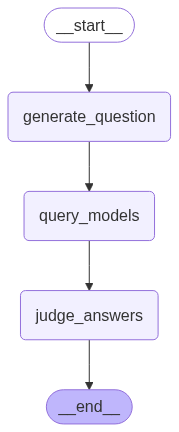

In [ ]:
workflow = StateGraph(GraphState)

# Add all nodes to the graph
workflow.add_node("generate_question", generate_question_node)
workflow.add_node("query_models", query_models_node)
workflow.add_node("prepare_for_judging", prepare_for_judging_node)
workflow.add_node("send_chunk_to_judge", send_chunk_to_judge_node)
workflow.add_node("check_next_chunk", check_next_chunk_node)
workflow.add_node("check_next_model", check_next_model_node)
workflow.add_node("final_judge", final_judge_node)

# Define the overall workflow edges
workflow.add_edge(START, "generate_question")
workflow.add_edge("generate_question", "query_models")
# The output of query_models now goes to the new prepare node
workflow.add_edge("query_models", "prepare_for_judging")

# Define the looping logic for the iterative judge
# 1. Start the loop by sending the first chunk
workflow.add_edge("prepare_for_judging", "send_chunk_to_judge")

# 2. Check if there are more chunks for the current model
workflow.add_conditional_edges(
    "send_chunk_to_judge",
    check_next_chunk_node,
    {
        # If there are more chunks, loop back to send the next one
        "continue": "send_chunk_to_judge",
        # If no more chunks, move on to the next model
        "end_chunk_loop": "check_next_model"
    }
)

# 3. Check if there are more models to judge
workflow.add_conditional_edges(
    "check_next_model",
    check_next_model_node,
    {
        # If there are more models, loop back to the start of the chunk loop
        "continue": "send_chunk_to_judge",
        # If all models are judged, proceed to final ranking
        "end_all_loops": "final_judge"
    }
)

# After the loop and final judge, the workflow ends
workflow.add_edge("final_judge", END)

# Compile the graph into a runnable app
app = workflow.compile()

print("LangGraph workflow compiled successfully!")

# Display the graph visualization
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")

## 6. Execute the Agent Workflow

**Purpose**: To run our newly created LangGraph agent. We prepare the initial state and then invoke the graph.

In [6]:
# Prepare the initial state for the graph.
initial_state = {
    "competitor_models": competitor_models
}

print("--- Invoking Agent Workflow ---")
final_state = None
try:
    # app.stream() executes the graph and streams the output of each node.
    # The 'final_state' variable will be updated after each step, so when
    # the loop finishes, it will hold the complete final state.
    for event in app.stream(initial_state):
        for node_name, updated_state in event.items():
            print(f"\n--- Output from Node: '{node_name}' ---")
            print(updated_state)
            final_state = updated_state # This captures the latest state

except Exception as e:
    print(f"An error occurred during the workflow execution: {e}")

print("\n--- Workflow Complete ---")

--- Invoking Agent Workflow ---
--- NODE: Generating Question ---

--- Output from Node: 'generate_question' ---
{'question': 'How does the concept of identity persistence challenge traditional metaphysical notions of the self, and what implications might this have for the development of artificial intelligence that seeks to mimic human cognitive processes?'}
--- NODE: Querying Competitor Models ---
  - Querying gpt-3.5-turbo...
  - Querying gpt-4o...
  - Querying gpt-4o-mini...

--- Output from Node: 'query_models' ---
{'answers': [{'model': 'gpt-3.5-turbo', 'answer': 'The concept of identity persistence challenges traditional metaphysical notions of the self by questioning the idea of a fixed, unchanging identity. Traditional metaphysical theories often posit a unified and consistent self that continues to exist over time, but identity persistence suggests that our sense of self is constantly evolving and can be influenced by external factors.\n\nThis has implications for the develop

In [7]:
print(final_state)

{'judgement': '{"results": [2, 3, 1]}'}
